## Florida Bird Feeder Bird Identifier

[Florida Backyard Feeder Birds](https://avianreport.com/florida-backyard-feeder-birds)

One of my favorite ideas for use of deep learning for hobbies is to build a motion capture video setup around our bird feeder.

This has multiple components we can break down:
- Detects the motion of nearby birds
- Records a short snippet
- Uses segmentation to identify all areas of the image that are "bird"
- For the bird(s) in all portions of the image, use deep learning to identify their breeds
- Save labeled videos and images somewhere with each breed, time taken, etc.
- Have an interface to look at the images/videos, as well as some stats for most frequent birds, etc.
- Have some feedback mechanism for most frequently incorrect birds, and flagging those with a high loss for review.

The first step is to just build a bird breed identifier for Florida Feeder birds.

In [1]:
import json
from pathlib import Path
import re
from time import sleep

from bs4 import BeautifulSoup
import httpx

from fastdownload import download_url
import fastai.vision.all as fai_vision
import fastai.data.all as fai_data
import timm

c:\Users\Danny\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# This site has the top 30 bird feeder birds in Florida
r = httpx.get("https://avianreport.com/florida-backyard-feeder-birds/")
r

<Response [200 OK]>

In [5]:
r.text[:100]

'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n<meta charset="UTF-8">\n<meta name="viewport" content="wid'

In [6]:
soup = BeautifulSoup(r.text)
bird_rows = soup.select_one("table").find_all("tr")
bird_rows[:3]

[<tr><td></td><td><strong>Bird Name</strong></td><td class="has-text-align-left" data-align="left"><strong>Percentage of Florida</strong><br/><strong>backyard feeders visited</strong></td></tr>,
 <tr><td>1</td><td>Northern Cardinal</td><td class="has-text-align-left" data-align="left">92</td></tr>,
 <tr><td>2</td><td>Mourning Dove</td><td class="has-text-align-left" data-align="left">86</td></tr>]

In [13]:
# The table on this page has the top 30 in order of frequency visiting feeder
# Feeder frequency is "Percentage of Florida backyard feeders visited" as reported by observations
birds = []
# The first column is the header
for row in bird_rows[1:]:
    bird_cols = row.find_all('td')
    birds.append({"bird_name": bird_cols[1].get_text(), "feeder_frequency": bird_cols[2].get_text()})

In [18]:
with Path("00-top-30-birds.json").open("w+") as f:
    json.dump(birds, f)

In [5]:
with Path("00-top-30-birds.json").open("r") as f:
    birds = json.load(f)
birds[:3]

[{'bird_name': 'Northern Cardinal', 'feeder_frequency': '92'},
 {'bird_name': 'Mourning Dove', 'feeder_frequency': '86'},
 {'bird_name': 'Red-bellied Woodpecker', 'feeder_frequency': '81'}]

In [2]:
def get_env_item(item: str, env_path = Path(".env")):
    """
    Simple utility function to get a key from a .env file.
    """
    env = env_path.open().read()
    res = re.search(item + r"=(.*)", env_path.open().read())
    if not res:
        raise Exception(f"{item} not found in env: {env_path}")
    return res.group(1)

In [3]:
# https://learn.microsoft.com/en-us/bing/search-apis/bing-image-search/quickstarts/rest/python
# https://learn.microsoft.com/en-us/bing/search-apis/bing-image-search/reference/query-parameters?source=recommendations
sub_key = get_env_item("BING_SUBSCRIPTION_KEY")
search_url = "https://api.bing.microsoft.com/v7.0/images/search"
headers = {"Ocp-Apim-Subscription-Key" : sub_key}
params  = {"license": "public", "imageType": "photo"}

In [62]:
search_params = {"q": birds[0]['bird_name'], **params}
search_params

res = httpx.get(search_url, headers=headers, params=search_params)

In [64]:
res.json()

{'_type': 'Images',
 'instrumentation': {'_type': 'ResponseInstrumentation'},
 'readLink': 'images/search?q=Northern Cardinal',
 'webSearchUrl': 'https://www.bing.com/images/search?q=Northern Cardinal&FORM=OIIARP',
 'queryContext': {'originalQuery': 'Northern Cardinal',
  'alterationDisplayQuery': 'northern cardinals',
  'alterationOverrideQuery': '+Northern Cardinal',
  'alterationMethod': 'AM_JustChangeIt',
  'alterationType': 'CombinedAlterationsChained'},
 'totalEstimatedMatches': 351,
 'nextOffset': 50,
 'currentOffset': 0,
 'value': [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=Northern+Cardinal&id=AEF829C423BDBEE453A9384AD7F17440D7E8C3B0&simid=608013992139630803',
   'name': 'Photo of Northern Cardinal Perched on Brown Tree Branch · Free Stock Photo',
   'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.3aLd8zPS3_y75zZCNFAifQHaE8&pid=Api',
   'datePublished': '2021-03-09T21:48:00.0000000Z',
   'isFamilyFriendly': True,
   'creativeCommons': 

In [72]:
im_url = res.json()['value'][0]['contentUrl']
im_url

'https://images.pexels.com/photos/3647326/pexels-photo-3647326.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260'

In [73]:
dest = "northern_cardinal.jpg"
download_url(im_url, dest)

Path('northern_cardinal.jpg')

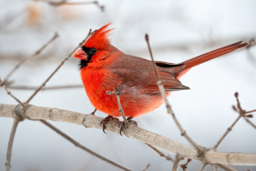

In [78]:
im = fai_vision.Image.open(dest)
im.to_thumb(256,256)

In [95]:
bird_name_path = '_'.join([o.lower() for o in birds[0]['bird_name'].split(' ')])
t = Path('./datasets')/'bird_id'/bird_name_path
t.mkdir(exist_ok=True)

In [98]:
birds[0]['bird_name']

'Northern Cardinal'

In [7]:
urls_downloaded = []
for bird in birds:
    bird_name = bird['bird_name']
    bird_name_path = '_'.join([o.lower() for o in bird_name.split(' ')])
    
    # We got the first bird search while testing
    # if bird_name == birds[0]['bird_name']:
    if bird_name in []:
        continue
        # bird_res = res
    else:
        bird_res = httpx.get(
            search_url, headers=headers, 
            params={"q": bird_name, "count": 150, **params}
        )
        bird_sun_res = httpx.get(
            search_url, headers=headers, 
            params={"q": f"{bird_name} sun", "count": 150, **params}
        )
        bird_shade_res = httpx.get(
            search_url, headers=headers, 
            params={"q": f"{bird_name} shade", "count": 150, **params}
        )

    bird_urls = [
        o['contentUrl'] for o in bird_res.json()['value'] 
        if o['contentUrl'] not in urls_downloaded
    ]
    urls_downloaded += bird_urls
    bird_urls += [
        o['contentUrl'] for o in bird_sun_res.json()['value'] 
        if o['contentUrl'] not in urls_downloaded
    ]
    urls_downloaded += bird_urls
    bird_urls += [
        o['contentUrl'] for o in bird_shade_res.json()['value'] 
        if o['contentUrl'] not in urls_downloaded
    ]
    urls_downloaded += bird_urls

    fai_vision.download_images(Path('./datasets')/'bird_id'/bird_name_path, urls=bird_urls)
    sleep(2)

In [8]:
# Cache urls so we can avoid downloading duplicates
# if we gather more in the future
with Path("00-bird-urls-dled.json").open("w+") as f:
    json.dump({"urls_downloaded": urls_downloaded}, f)

In [9]:
len(urls_downloaded)

13972

In [11]:
failed = fai_vision.verify_images(
    fai_vision.get_image_files(Path('./datasets/bird_id/'))
)
failed.map(Path.unlink)
len(failed)

1

In [12]:
for bird in birds:
    bird_name = bird['bird_name']
    bird_name_path = '_'.join([o.lower() for o in bird_name.split(' ')])

    bird_path = Path("./datasets/")/'bird_id'/bird_name_path
    path_list = bird_path.glob("*")
    print(f"{bird_name}: {len(list(path_list))}")

Northern Cardinal: 209
Mourning Dove: 193
Red-bellied Woodpecker: 207
Blue Jay: 210
Northern Mockingbird: 158
Tufted Titmouse: 187
Carolina Wren: 215
American Goldfinch: 202
Yellow-rumped Warbler: 107
Downy Woodpecker: 140
Carolina Chickadee: 158
Gray Catbird: 234
House Finch: 142
American Crow: 197
Pine Warbler: 155
Common Grackle: 186
Chipping Sparrow: 196
Ruby-throated Hummingbird: 202
Brown Thrasher: 243
American Robin: 251
Painted Bunting: 180
Common Ground-Dove: 133
Brown-headed Cowbird: 171
House Sparrow: 107
Red-winged Blackbird: 194
Eastern Bluebird: 175
White-winged Dove: 71
Baltimore Oriole: 176
Eurasian Collared Dove: 78
Indigo Bunting: 115


In [13]:
# We'll never need the images very large, shrink them to save disk space and for efficiency
fai_vision.resize_images(
    Path("./datasets/bird_id/"), 
    dest=Path("./datasets/bird_id/"),
    max_size=400,
    recurse=True
)

In [3]:
bird_id = fai_data.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_data.CategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_data.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fai_data.parent_label,
    # item_tfms=[fai_vision.RandomResizedCrop(224, min_scale=0.5)]
    item_tfms=[fai_vision.Resize(224)]
)
dls = bird_id.dataloaders(Path("./datasets/bird_id/"))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


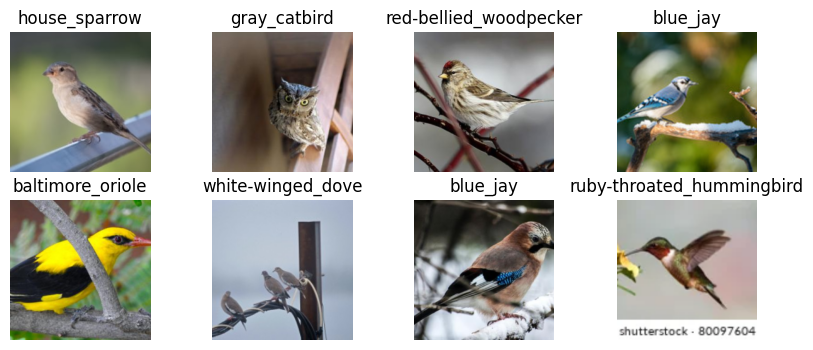

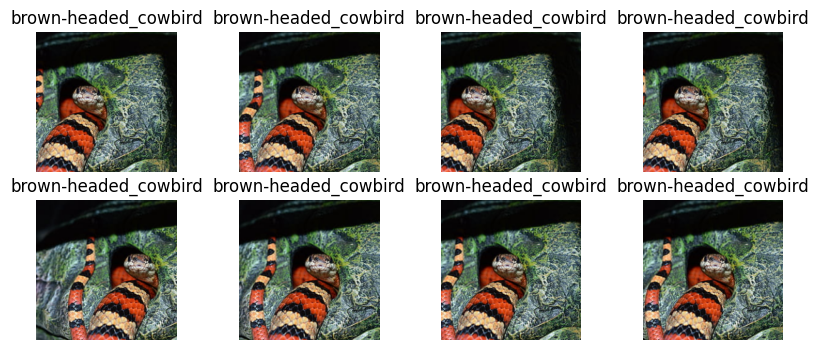

In [ ]:
dls.show_batch(max_n=8, nrows=2, figsize=(10,4))
dls.show_batch(max_n=8, nrows=2, figsize=(10,4), unique=True)

In [8]:
fai_vision.torch.cuda.empty_cache()

In [4]:
# Resnet 18 accuracy after 5 epochs 54%
# Resnet 50 = 55%
learner = fai_vision.vision_learner(
    dls, fai_vision.resnet50, metrics=fai_vision.accuracy
)

c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.158135,2.261139,0.491564,00:49


epoch,train_loss,valid_loss,accuracy,time
0,1.810817,1.719219,0.563555,00:51
1,1.501185,1.769356,0.586052,00:46
2,1.058977,1.742019,0.613048,00:44
3,0.650220,1.713153,0.618673,00:48
4,0.409910,1.712609,0.622047,00:46


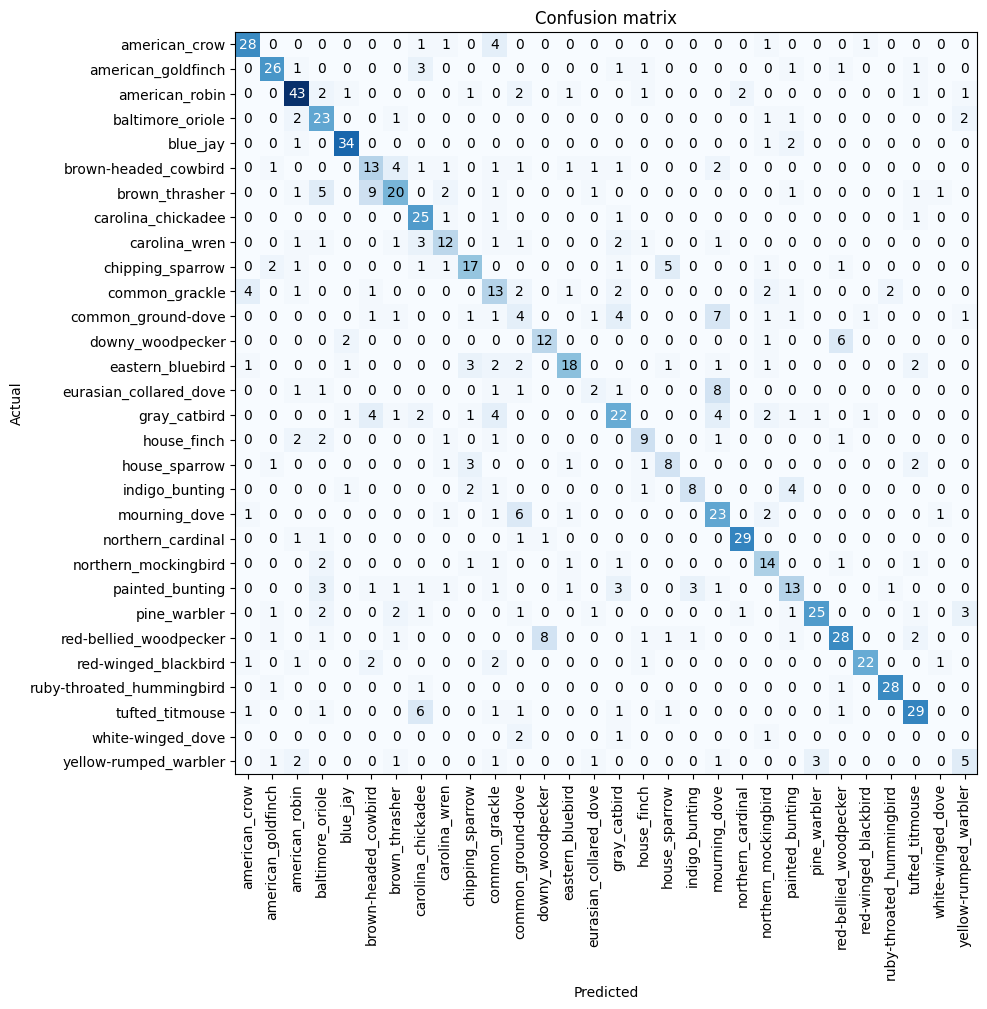

In [7]:
interp = fai_vision.ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,10))

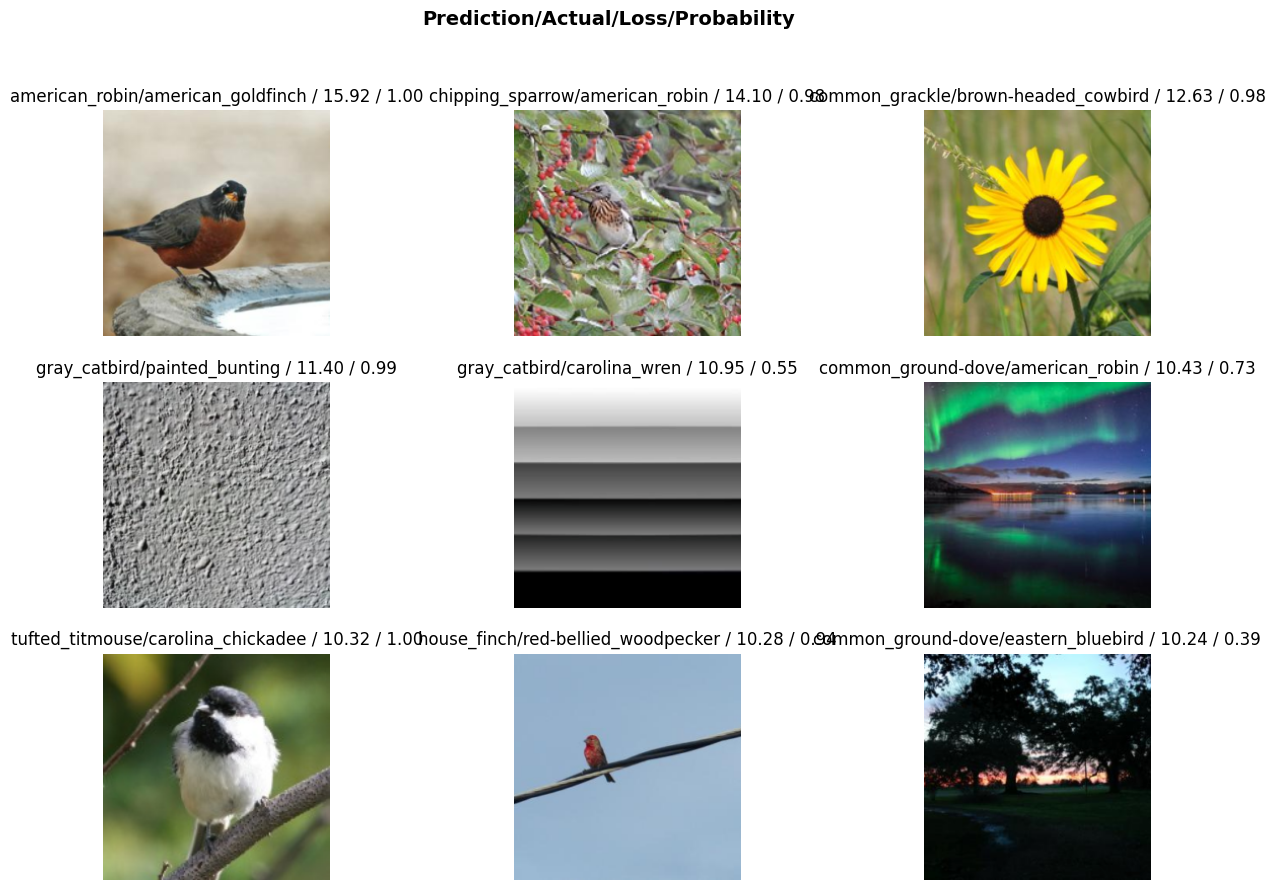

In [10]:
interp.plot_top_losses(9, nrows=3, figsize=(15, 10))

In [20]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learner)
cleaner

Creating an initial model with resnets 18 and 50 using my first dataset produced
an accuracy of only up to 50%. Upon showing the confusion matrix, it was clear
that the source of confusion is the subtypes of various birds. 

This was with around 30-35 images per bird.

Birds that are fairly unique got very high accuracy: Northern Cardinal, ruby-throated hummingbird,
blue jay.

However, all the dove types for example (ground dove, eurasian collared dove, mourning dove)
were essentially equally guessed between.

I think I will need a lot more data to have decent accuracy. I'll start with
re-downloading the data and hashing the URLs so I can add more data later without duplicates.

However, data cleaning will definitely be necessary as well, I see a red-throated lizard in one of the top losses.

After upgrading to around 100-200 images per bird, still only got 57% with resnet18.
Checking the top losses shows a ton of data quality issues, so I started cleaning at this point instead of gathering more data.

When I ran the fastai cleaner, there were a TON of junk images for every one of the 3 species I looked at.
There were very obscure photos, incorrect bird names, different species, things that weren't images at all.

I ended up deciding that it was insane to try to gather good data for this via api searches. 
There are too many categories for me to manually comb through. 
Furthermore, the fact that different birds have different looks at various ages, breeding stages, and genders makes this a monumental task.

I'm amazed I was even able to get close to 60% on 30 species. I think ultimately this high accuracy was carried by certain breeds of birds that are easier to recognize, and for which photos are commonly only for adult males (e.g. northern cardinals and bluejays). Even these would fall apart in the real world with various genders and ages.

Found a great bird dataset from the [Cornell Lab of Ornithology](https://dl.allaboutbirds.org/nabirds).
It's for non-commercial use, but should work perfect here.

In [12]:
def clean_bird_name_path(bird_name: str) -> str:
    bird_name_path = re.sub(r"[ \/]", "_", bird_name)
    bird_name_path = re.sub(r"[A-Z]", lambda m: m.group(0).lower(), bird_name_path)
    return bird_name_path

In [15]:
import shutil


with Path("00-top-30-nabird-paths.json").open("r") as f:
    nabird_paths = json.load(f)

nabird_base_path = Path(r"D:\Storage\dls\nabirds.tar\nabirds")
dest_base_path = Path("./datasets/bird_id")

for bird_name, paths in nabird_paths.items():
    for path in paths:
        orig_path = nabird_base_path/path
        bird_name_path = clean_bird_name_path(bird_name)
        dest_path = dest_base_path/bird_name_path
        dest_path.mkdir(exist_ok=True)
        shutil.copy2(orig_path, dest_path/orig_path.name)

In [16]:
fai_vision.resize_images(
    Path("./datasets/bird_id/"), 
    dest=Path("./datasets/bird_id/"),
    max_size=400,
    recurse=True
)

In [4]:
bird_id = fai_data.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_data.CategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_data.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fai_data.parent_label,
    # item_tfms=[fai_vision.RandomResizedCrop(224, min_scale=0.5)]
    item_tfms=[fai_vision.Resize(224)]
)
dls = bird_id.dataloaders(Path("./datasets/bird_id/"))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


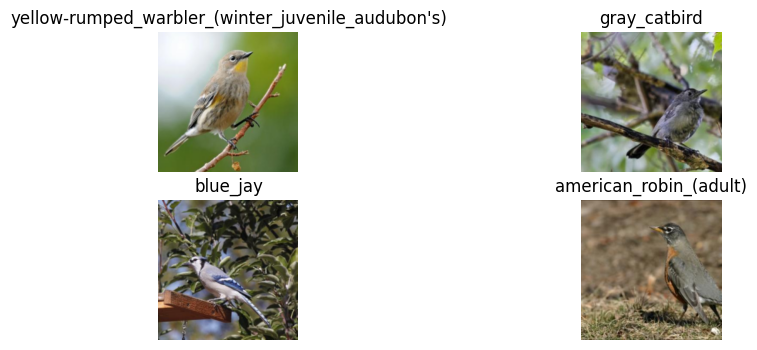

In [3]:
dls.show_batch(max_n=4, nrows=2, figsize=(10,4))

In [4]:
learner = fai_vision.vision_learner(
    dls, fai_vision.resnet18, metrics=fai_vision.accuracy
)

c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.413736,1.335087,0.620216,00:52


epoch,train_loss,valid_loss,accuracy,time
0,1.334408,0.890929,0.734053,00:40
1,0.925108,0.737949,0.782139,00:36
2,0.569364,0.675280,0.788027,00:37
3,0.326155,0.681861,0.799804,00:42
4,0.214475,0.681853,0.794897,00:44


In [4]:
learner = fai_vision.vision_learner(
    dls, fai_vision.resnet50, metrics=fai_vision.accuracy
)

c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.466368,1.055439,0.701668,01:06


epoch,train_loss,valid_loss,accuracy,time
0,0.746279,0.681714,0.801766,01:02
1,0.520393,0.678628,0.815505,01:08
2,0.303658,0.570911,0.837095,00:55
3,0.146892,0.508233,0.871443,01:04
4,0.079291,0.486613,0.868499,00:58


In [3]:
learner = fai_vision.vision_learner(
    dls, 'convnext_tiny.in12k_ft_in1k_384', metrics=fai_vision.accuracy
)

model.safetensors: 100%|██████████| 114M/114M [00:17<00:00, 6.58MB/s] 


In [4]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.538983,0.294043,0.897939,01:09


epoch,train_loss,valid_loss,accuracy,time
0,0.341952,0.200005,0.932287,02:43
1,0.259997,0.224260,0.931305,02:47
2,0.155811,0.189889,0.935231,03:08
3,0.098037,0.170054,0.945044,03:19
4,0.069970,0.167985,0.943081,03:42


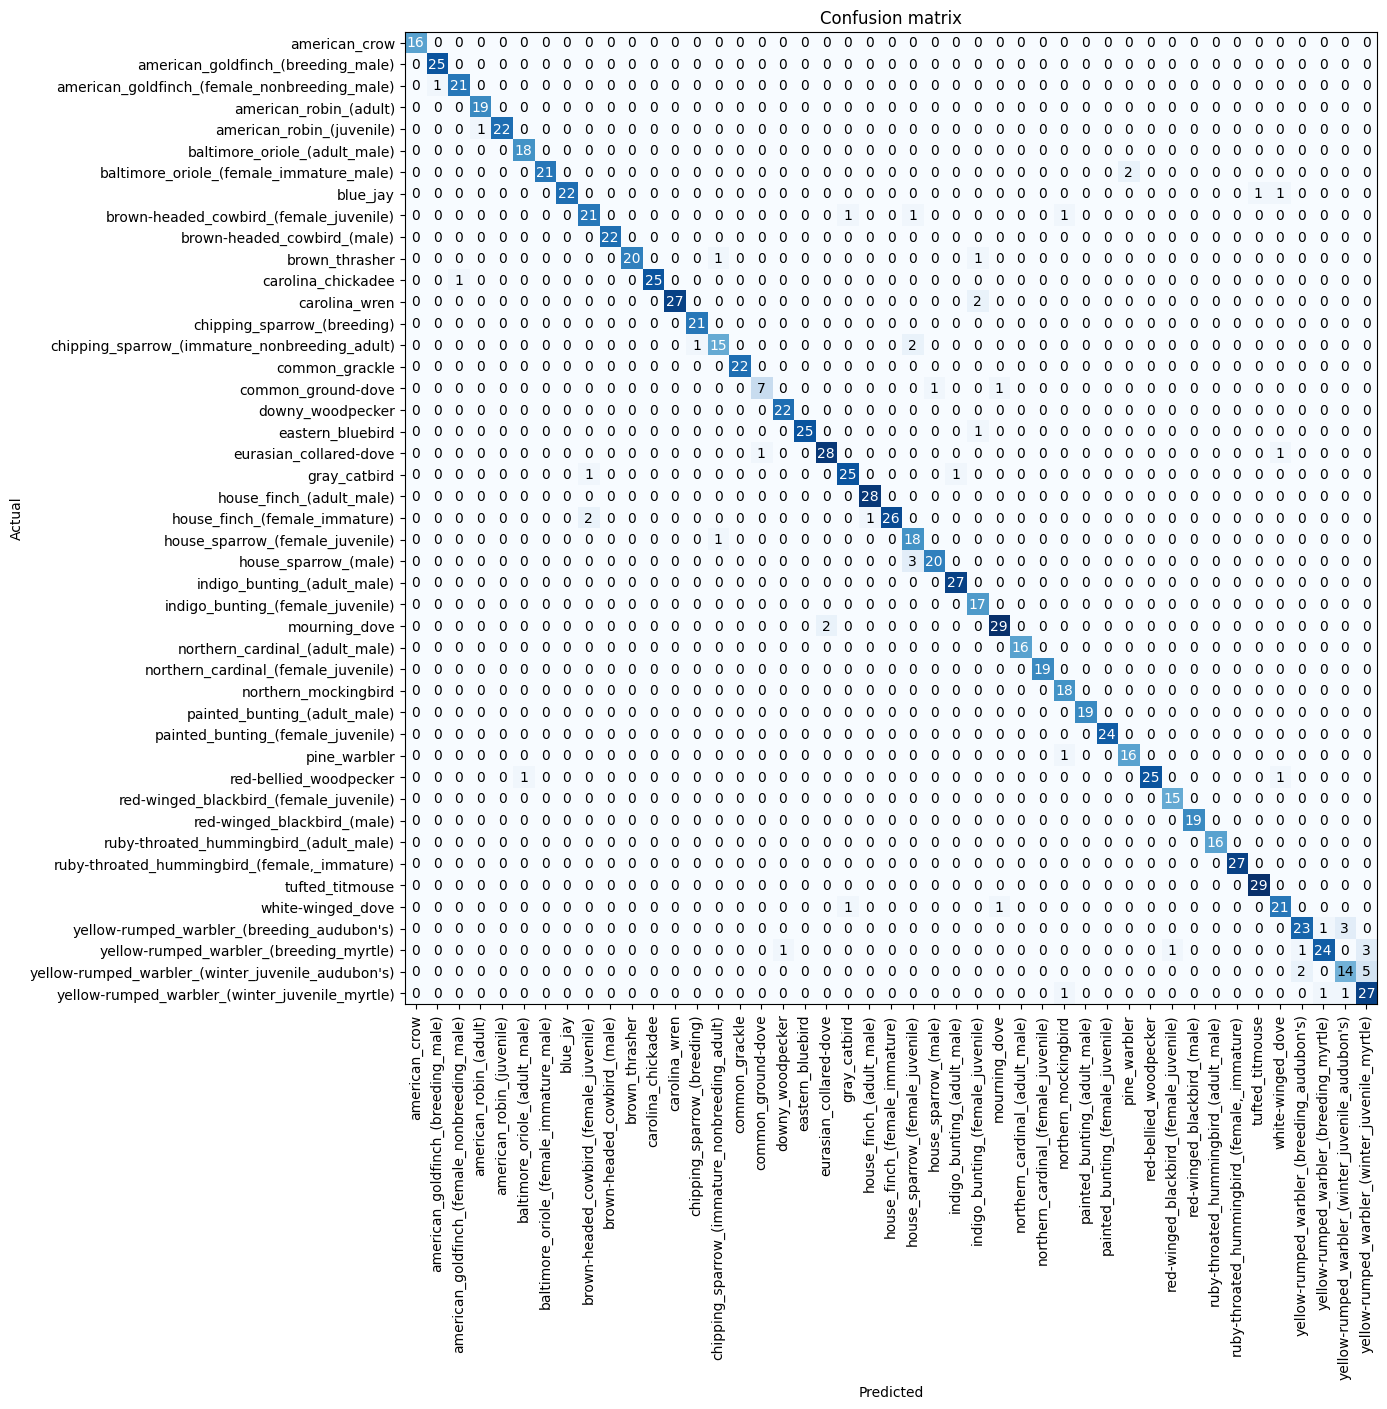

In [5]:
interp = fai_vision.ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(14,14))

In [6]:
learner.save("00-bird-identifier-convnexttiny")

Path('models/00-bird-identifier.pth')

In [7]:
learner = fai_vision.vision_learner(
    dls, 'convnext_tiny.in12k_ft_in1k_384', metrics=fai_vision.accuracy
)
learner.load("00-bird-identifier-convnexttiny")

Prediction: northern_cardinal_(adult_male), Probability: 99.997%


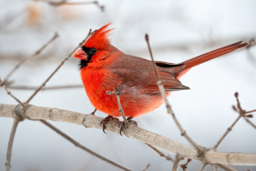

In [18]:
test_image = "./00-northern_cardinal.jpg"
pred, pred_idx, probs = learner.predict(test_image)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]*100:0.03f}%")
im = fai_vision.Image.open(test_image)
im.to_thumb(256,256)

Prediction: red-bellied_woodpecker, Probability: 99.912%


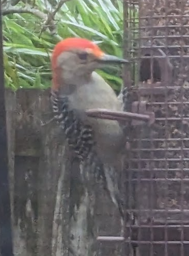

In [19]:
test_image = "./00-red-bellied_woodpecker1.png"
pred, pred_idx, probs = learner.predict(test_image)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]*100:0.03f}%")
im = fai_vision.Image.open(test_image)
im.to_thumb(256,256)

Prediction: red-bellied_woodpecker, Probability: 99.970%


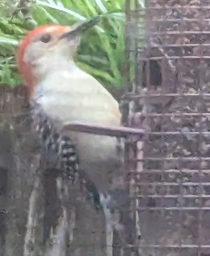

In [20]:
test_image = "./00-red-bellied_woodpecker2.png"
pred, pred_idx, probs = learner.predict(test_image)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]*100:0.03f}%")
im = fai_vision.Image.open(test_image)
im.to_thumb(256,256)

Prediction: carolina_chickadee, Probability: 100.000%


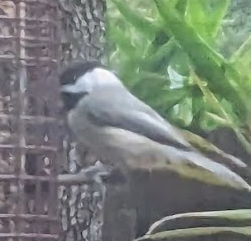

In [21]:
test_image = "./00-chickadee1.png"
pred, pred_idx, probs = learner.predict(test_image)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]*100:0.03f}%")
im = fai_vision.Image.open(test_image)
im.to_thumb(256,256)